# Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import joblib

import time
import os

# Import Data

In [2]:
def import_data(file_path):
    # Read data from the specified file path
    df_raw=pd.read_csv(file_path)

    # Return the imported DataFrame
    return df_raw

# Cleaning Data

# Feature Engineering

In [3]:
def calculate_alt_change(df):

    # Add new column with calculated Altitude Change
    df['Alt(m)_change'] = df['Alt(m)'].diff().fillna(0)

    # Remove outliers
    # Set the threshold value for filtering
    alt_threshold = 20

    # Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
    df = df[df['Alt(m)_change'].abs() <= alt_threshold]

    return df

# option to add log file later on
# print shape before and after outlier detection and removal

In [4]:
def plot_alt_changes(df):

    # Create a histogram plot
    plt.hist(df['Alt(m)_change'],
             bins=20,
             color='skyblue',
             edgecolor='black')

    #Add labels and title
    plt.xlabel('Altitude (m)')
    plt.ylabel('Frequency')
    plt.title('Altitude Changes')

    #Show the plot
    plt.show()

In [5]:
def calculate_speed_change(df):

    # Add new column with calculated Speed Change
    df['Speed(m/s)_change'] = df['Speed(m/s)'].diff().fillna(0)

    # Remove outliers
    # Set the threshold value for filtering
    threshold_speed = 3

    # Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
    df = df[df['Speed(m/s)_change'].abs() <= threshold_speed]

    return df

    # option to add log file later on
    # print shape before and after outlier detection and removal

In [6]:
def plot_speed_changes(df):

    # Create a histogram plot
    plt.hist(df['Speed(m/s)_change'],
             bins=20,
             color='skyblue',
             edgecolor='black')

    #Add labels and title
    plt.xlabel('Speed Change (m/s)')
    plt.ylabel('Frequency')
    plt.title('Speed Changes')

    #Show the plot
    plt.show()

In [7]:
def calculate_course_change(df):

    # Add new column with calculated Course Change
    df['Course_change'] = df['Course'].diff().fillna(0)

    return df

    # option to add log file later on
    # print shape before and after outlier detection and removal

In [8]:
def convert_datetime(df):

    # Convert 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ns')

    return df

# Prediction

In [9]:
def select_features(df):

    features_to_use = ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)', 'accelUserY(g)',
       'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)', 'gyroZ(rad/s)',
       'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'Lat', 'Long', 'Speed(m/s)',
       'HorizontalAccuracy(m)', 'VerticalAccuracy(m)', 'Course', 'calMagX(µT)',
       'calMagY(µT)', 'calMagZ(µT)', 'Alt(m)_change',
       'Speed(m/s)_change', 'Course_change']

    X=df[features_to_use]

    return X

In [10]:
def load_model(file_path_to_model):

    # Load the saved model
    return joblib.load(file_path_to_model)


In [11]:
def show_hyperparameters(model):
    # show hyperparameters
    return model.get_params()


In [12]:
def predict_on_features(model, df, features):

    predictions=model.predict(features)

    df['predicted']=predictions

    return df


# Visualisation

### Plotting

In [109]:
def plot_prediction(df, target_column='predicted'):
    # Define the plot title based on the target column
    if target_column == 'on_lift':
        plot_title = 'Predictions'
    elif target_column == 'mask':
        plot_title = 'Predictions on cleaned classification'
    elif target_column == 'event':
        plot_title = 'Lift Events'
    else:
        plot_title = 'Predictions'
        
    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Create a scatter plot for Altitude over Time, colored by target_column with an accessible color scheme
        fig = px.scatter(df, x='Timestamp', 
                         y='Alt(m)', color=target_column,                       
                         labels={'Alt(m)': 'Altitude (m)'},
                         title=plot_title,
                         color_discrete_map={'0': 'blue', '1': 'orange', '2': 'green'})

        fig.update_traces(marker=dict(size=8),
                          selector=dict(mode='markers'))

        # Customize the legend
        fig.update_layout(
            legend_title_text='Status',
            width=1000,
            height=600
        )

        # Update legend labels based on target_column
        if target_column == 'on_lift':
            fig.for_each_trace(lambda trace: trace.update(name='Not on the lift' if trace.name == '0' else 'On the lift'))
        # Add more conditions if there are different classes for other target_columns

        # Show the plot
        fig.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")


In [14]:
def plot_total_alt_over_time(df, plot_title='Total Tracked Altitude Over Time'):

    # Create a line plot using Plotly
    fig = go.Figure()

    # Add a trace for altitude over time
    fig.add_trace(go.Scatter(x=df['Timestamp'],
                             y=df['Alt(m)'],
                             mode='lines',
                             name='Altitude'))

    # Update layout
    fig.update_layout(title=plot_title,
                      xaxis_title='Timestamp',
                      yaxis_title='Altitude (m)')

    # Show plot
    fig.show()

### Mapping

In [15]:
#Map all tracked movement based on lat and long of GPS data  

def map_tracked_movement(df, zoom_start=12):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(), df['Long'].mean()]
    movement_on_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Add CircleMarkers for each data point
    for index, row in df.iterrows():
        folium.CircleMarker(location=[row['Lat'], row['Long']], radius=5, color='blue', fill=True, fill_color='blue').add_to(movement_on_map)
    
    # Display the map
    return movement_on_map

In [16]:
#Map lifts rides in red and all the other movement in blue 

def map_lifts_and_other_movement(df, column='on_lift', zoom_start=15):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(), df['Long'].mean()]
    tracking_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Plot data points with on_lift type
    on_lift = df[df[column] == 1]
    for _, row in on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'], row['Long']], radius=5, color='red', fill=True, fill_color='red', tooltip=str(row['Timestamp'])).add_to(tracking_map)

    # Plot data points with not_on_lift  types
    not_on_lift = df[df[column] != 1]
    for _, row in not_on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'], row['Long']], radius=5, color='blue', fill=True, fill_color='blue', tooltip=str(row['Timestamp'])).add_to(tracking_map)

    # Return the map object
    return tracking_map

In [35]:
#Map only lifts rides

def map_lift_rides(df, column='on_lift', zoom_start=15):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(), df['Long'].mean()]
    lift_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Plot data points with on_lift type
    on_lift = df[df[column] == 1]
    for _, row in on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'],
                                      row['Long']],
                                      radius=5,
                                      color='red',
                                      fill=True,
                                      fill_color='red',
                                      tooltip=str(row['Timestamp'])).add_to(lift_map)

    # Return the map object
    return lift_map

# Prediction steps in one function

In [114]:
# use this to predict on a csv that already has all data points
def predict_on_data(path_to_csv_file, file_path_to_model):

    # Load the data
    df = pd.read_csv(path_to_csv_file)

    # Preprocess and feature engineering
    df = calculate_alt_change(df)
    df = calculate_speed_change(df)
    df = calculate_course_change(df)
    df = convert_datetime(df)

    # Feature selection
    features = select_features(df)

    # Load the model
    rfc = joblib.load(file_path_to_model)

    # Make predictions
    df = predict_on_features(rfc, df, features)
    # Update preidctions with mask
    df = generate_misclassification_mask(df)

    # Plot predictions
    plot_prediction(df, target_column='mask')

    return df



# Post-Processing 

In [111]:
# Function for masking misclassification, this mask should then be applied and the new input be used for plotting 

def generate_misclassification_mask(df, column_to_mask='predicted', chunk_size=60, threshold=0.3):
    """
    Apply a binary mask to each row in a DataFrame based on the average value of a specified column in chunks.

    Parameters:
    - df: pandas.DataFrame, the DataFrame to process.
    - column_to_mask: str, the name of the column to evaluate.
    - chunk_size: int, the number of rows in each chunk.
    - threshold: float, the threshold for determining the mask value.

    Returns:
    - df: pandas.DataFrame, the original DataFrame with an added 'mask' column.

    Example usage:
    - Assuming df_option3 is your DataFrame and already defined.
    - df_option3 = pd.DataFrame(...)
    - df_with_mask = apply_mask_based_on_threshold(df_option3, 'predicted', 60, 0.3)
    - print(df_with_mask)
    
    """
    # Calculate the total number of chunks
    total_chunks = len(df) // chunk_size

    # Initialize an empty list to store all calculations
    all_calculations = []

    # Process each chunk
    for i in range(total_chunks):
        # Fetch a chunk of data
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        data_chunk = df[column_to_mask].iloc[start_index:end_index]

        # Process the chunk based on the sum of values
        processed_chunk = [1 if sum(data_chunk)/len(data_chunk) >= threshold else 0] * len(data_chunk)
        # Append the processed chunk to the list of all calculations
        all_calculations += processed_chunk

    # Process remainder if any
    remainder = len(df) % chunk_size
    if remainder > 0:
        remainder_data_chunk = df[column_to_mask].iloc[-remainder:]
        processed_chunk = [1 if sum(remainder_data_chunk)/len(remainder_data_chunk) >= threshold else 0] * len(remainder_data_chunk)
        all_calculations += processed_chunk

    # Assign the calculated mask to the DataFrame
    df['mask'] = all_calculations
    return df.reset_index()


In [112]:
# Function for defining on-lift identification

def on_lift_event_identification(df, column_to_mask='predicted', chunk_size=60, threshold=0.3):
    """
    # Example usage:
    # df_option3 = pd.DataFrame(...) # Assuming df_option3 is your DataFrame
    # df_on_lift = on_lift_event_identification(df_option3, 'predicted', 60, 0.3)
    # print(df_on_lift)
    
    """

    # Calculate the total number of chunks and remainder
    total_chunks = len(df) // chunk_size
    remainder = len(df) % chunk_size

    # Initialize an empty list for calculations and a dictionary for event logging
    all_calculations = []
    event_log = {}

    # Process each chunk
    for i in range(total_chunks):
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        data_chunk = df[column_to_mask].iloc[start_index:end_index]

        # Process the chunk
        if sum(data_chunk) / len(data_chunk) >= threshold:
            processed_chunk = [1] * len(data_chunk)
            event_log[i] = (start_index, end_index)
        else:
            processed_chunk = [0] * len(data_chunk)

        all_calculations += processed_chunk

    # Process remainder
    if remainder:
        remainder_data_chunk = df[column_to_mask].iloc[-remainder:]
        if sum(remainder_data_chunk) / len(remainder_data_chunk) >= threshold:
            processed_chunk = [1] * len(remainder_data_chunk)
        else:
            processed_chunk = [0] * len(remainder_data_chunk)
        all_calculations += processed_chunk
        # Optionally log remainder chunk if it meets the threshold
        if sum(remainder_data_chunk) / len(remainder_data_chunk) >= threshold:
            event_log[total_chunks] = (len(df) - remainder, len(df))

    # Assign calculated masks to the DataFrame
    df['mask'] = all_calculations

    ## Storing in a dict instead

    continuous_events_dict = {}
    event_index = 1

    start = None
    end = None

    for key in sorted(event_log.keys()):
        if start is None:
            start, end = event_log[key]
        elif end == event_log[key][0]:
            end = event_log[key][1]
        else:
            continuous_events_dict[event_index] = (start, end)
            event_index += 1
            start, end = event_log[key]
    # Append the last continuous event
    if start is not None and end is not None:
        continuous_events_dict[event_index] = (start, end)

    print("Continuous events as dictionary:")
    for key, value in continuous_events_dict.items():
        print(f"{key}: {value}")

    print('number of continuous events:', len(continuous_events_dict))

    df['event']=0
    for label in continuous_events_dict:
      range_val = [x for x in range(continuous_events_dict[label][0], continuous_events_dict[label][1] + 1)]
      df.loc[range_val, 'event'] = label


    return df




# "Real time" prediction simulation 

### TO DO / TO BE FINISHED 

fetch_and_process_data_beta_v0.1

In [38]:
def fetch_and_process_data_beta(path_to_csv_file, chunk_size=60, wait_time=2):

    # Load the dataset
    df_with_all_rows = pd.read_csv(path_to_csv_file)

    # Calculate the total number of chunks
    total_chunks = len(df_with_all_rows) // chunk_size

    # Initialize an empty list to store all calculations
    all_calculations = pd.DataFrame()

    fig = px.scatter()

    for i in range(total_chunks):
        # Fetch a chunk of 60 observations
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        data_chunk = df_with_all_rows.iloc[start_index:end_index]

        if len(data_chunk) > 0:

            # Append the processed chunk to the list of all calculations
            all_calculations = pd.concat([all_calculations, data_chunk], ignore_index=True)

            # Preprocess and feature engineering
            df = calculate_alt_change(all_calculations)
            df = calculate_speed_change(df)
            df = calculate_course_change(df)
            df = convert_datetime(df)

            # print(df.shape)

            # Feature selection
            features = select_features(df)

            # # Make predictions
            df = predict_on_features(rfc, df, features)


# To do before going for one of the above mentioned options

Make sure that specify the paths and other variables needed

In [21]:
# These are the default values used in the function fetch_and_process_data, change if needed
chunk_size=60
wait_time=2

In [115]:
# Specify the file path to directory with data to predict on
path_to_df_95='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/v5_20230407_091351_95m.csv'
path_to_df_95_labelled='/Users/ze/Documents/Coding/Projects/2024/alturos/data/processed/df_95_labeled_on_lift.csv'
path_to_df_310='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/v5_20230408_082538_310m.csv'
path_to_df_Natschen_18='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/Natschen-2024-02-04_12-04-18.csv'
path_to_df_Natschen_46='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/Natschen-2024-02-04_12-01-46.csv'

In [118]:
# Specify the file path to pre-trained model
path_to_model_0_1 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.1.pkl'
path_to_model_0_2 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.2.pkl'
path_to_model_0_3 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.3.pkl'
path_to_model_0_4 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.4.pkl'
path_to_model_0_5 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.5.pkl'

In [33]:
df=import_data(path_to_df_95_labelled)

# Option 1: 'Real time' prediction

In [ ]:
# # Call this function to simulate prediction in 'real time'
# fetch_and_process_data(path_to_csv_file,
#                        chunk_size=60,
#                        wait_time=0.1)

# Option 2: One step to prediction

In [122]:
path_to_model=path_to_model_0_4

----- df_Natschen_18 -----


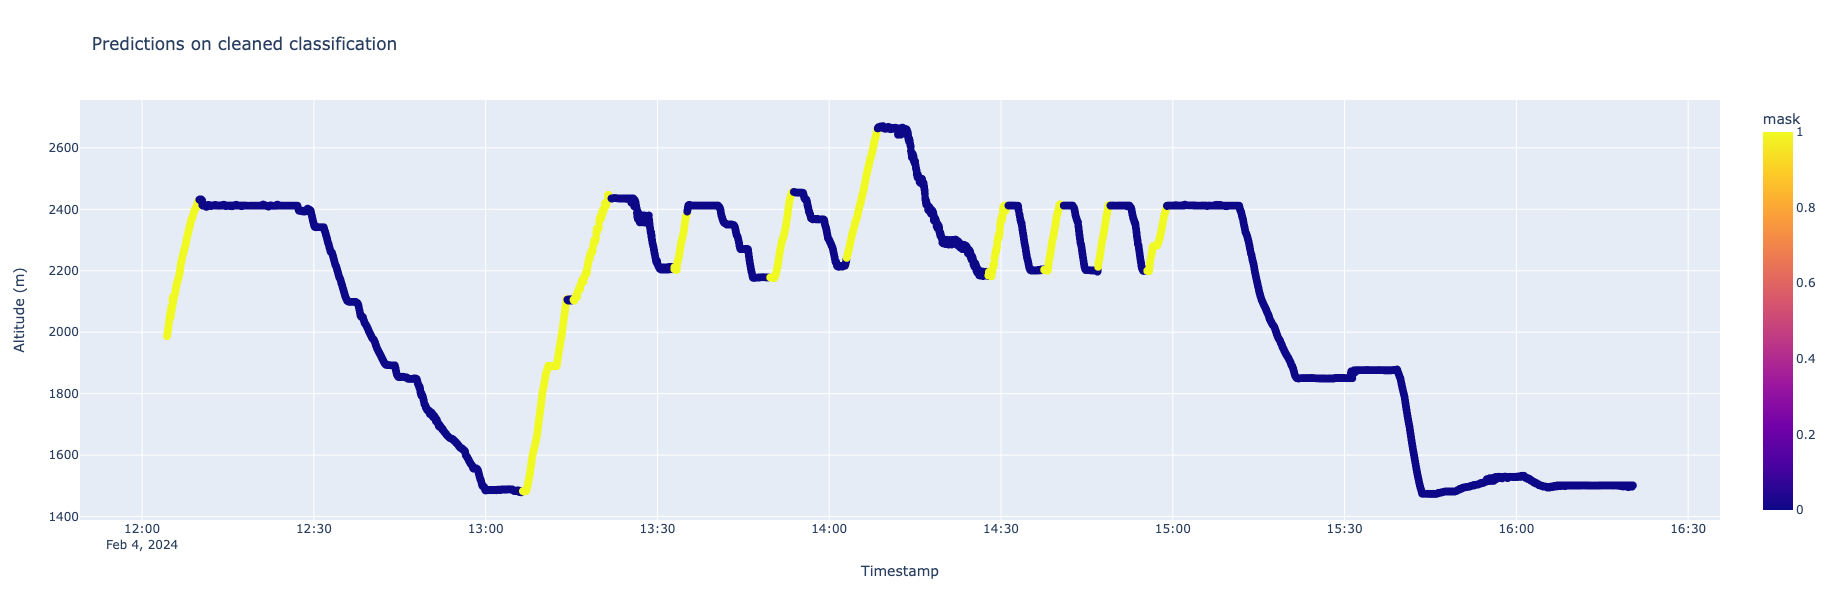

,index,Timestamp,gyroZ(rad/s),gyroY(rad/s),gyroX(rad/s),accelUserZ(g),accelUserY(g),accelUserX(g),RelativeAltitude(meters),Pressure(kilopascals),...,qX,qW,Roll(rads),Pitch(rads),Yaw(rads),Alt(m)_change,Speed(m/s)_change,Course_change,predicted,mask
0,0,2024-02-04 12:04:21,-0.065363,-0.125838,0.250760,-0.570151,-0.268100,-0.155515,5.805054,817.952148,...,0.076513,0.022867,-0.151347,-0.296693,-3.117877,0.000000,0.000000,0.000000,1,1
1,1,2024-02-04 12:04:22,-0.119119,-0.167988,0.095600,0.246928,0.485855,0.430333,7.427490,817.788330,...,-0.059797,0.229946,-0.175577,-0.207323,2.654868,1.495975,0.084153,-0.427826,1,1
2,2,2024-02-04 12:04:25,0.155771,-1.723250,0.555887,8.492921,-0.818095,-4.234797,13.473022,817.177979,...,0.615225,0.285861,-1.320245,-0.282852,-2.618086,7.582333,-0.338485,-3.400085,1,1
3,3,2024-02-04 12:04:26,-0.282830,1.038776,0.667370,2.039972,0.733955,0.831849,15.584106,816.964844,...,0.205209,0.313601,-0.339612,-0.315101,-2.540272,1.692061,0.231717,2.798534,1,1
4,4,2024-02-04 12:04:27,-0.051924,0.738230,0.173180,0.687331,1.449308,0.695577,17.875000,816.733887,...,0.086031,0.345454,-0.051739,-0.360524,-2.433196,1.149279,-0.009276,0.082672,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13226,13263,2024-02-04 16:20:16,0.389732,0.432492,0.043371,-0.167683,-0.032761,-0.547985,-461.961914,866.312012,...,0.039407,0.061678,-0.047589,-0.591576,-3.027017,0.000000,0.024710,12.942795,0,0
13227,13264,2024-02-04 16:20:18,-0.205251,0.041844,0.211970,1.216386,0.785843,-0.050984,-461.972534,866.312988,...,0.007494,0.026373,-0.000737,-0.530528,-3.087128,0.000000,0.039952,8.614670,0,0
13228,13265,2024-02-04 16:20:20,-0.087965,0.081550,-0.334448,0.738235,-0.051344,-1.529869,-462.297485,866.347412,...,0.027480,0.052857,0.026941,-0.578410,3.039249,0.000000,0.003558,0.707458,0,0
13229,13266,2024-02-04 16:20:21,-0.788016,-0.476169,-0.605367,2.307050,0.950288,-0.498330,-461.988403,866.314697,...,0.036519,0.029257,0.063816,-0.554763,3.098890,0.000000,0.007899,0.530472,0,0


In [123]:
# print('accuracy_score----- df_95 -----')
# predict_on_data(path_to_df_95, path_to_model)
# print('----- df_310 -----')
# predict_on_data(path_to_df_310, path_to_model)
print('----- df_Natschen_18 -----')
predict_on_data(path_to_df_Natschen_18, path_to_model)

In [121]:
# print('----- df_Natschen_46 -----')
# predict_on_data(path_to_df_Natschen_46, path_to_model)

# Option 3: Go through everything step by step

In [ ]:
df_option3=import_data(path_to_csv_file)

In [ ]:
df_option3=calculate_alt_change(df_option3)

In [ ]:
df_option3=calculate_speed_change(df_option3)

In [ ]:
df_option3=calculate_course_change(df_option3)

In [ ]:
df_option3=convert_datetime(df_option3)

In [ ]:
features=select_features(df_option3)

In [ ]:
rfc=load_model(file_path_to_model)

In [ ]:
df_option3=predict_on_features(rfc, df_option3, features)

In [ ]:
plot_prediction(df_option3)